In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

2025-11-07 18:20:48.262110: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-07 18:20:48.290336: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-07 18:20:48.850401: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow version: 2.20.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import os
from PIL import Image
import numpy as np
import tensorflow as tf

# Define image directories
low_light_dir = "/home/hp/Downloads/All_Old_Folders/CV/Projects/Enhanced_ELIEI/data_root/train/low"  # Directory containing low-light images
enhanced_dir = "/home/hp/Downloads/All_Old_Folders/CV/Projects/Enhanced_ELIEI/data_root/train/high"  # Directory containing enhanced images

# Define image loading and preprocessing function
def load_image(image_path, size=(256, 256)):
    img = Image.open(image_path)
    img = img.resize(size)  # Resize the images to 256x256
    img = np.array(img).astype(np.float32) / 255.0  # Normalize to [0,1]
    return img

# Load all images into arrays
low_light_images = []
enhanced_images = []

for img_name in os.listdir(low_light_dir):
    low_img_path = os.path.join(low_light_dir, img_name)
    enhanced_img_path = os.path.join(enhanced_dir, img_name)  # Assuming matching file names

    # Append loaded and processed images
    low_light_images.append(load_image(low_img_path))
    enhanced_images.append(load_image(enhanced_img_path))

# Convert lists to numpy arrays
low_light_array = np.array(low_light_images)
enhanced_array = np.array(enhanced_images)

# Convert the arrays to float32
low_light_array = low_light_array.astype(np.float32)
enhanced_array = enhanced_array.astype(np.float32)

print("Dataset Loaded. Shape of low-light images:", low_light_array.shape)

Dataset Loaded. Shape of low-light images: (236, 256, 256, 3)


In [4]:
def unet_model(input_shape=(256, 256, 3)):
    inputs = tf.keras.layers.Input(input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    bottleneck = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)

    # Decoder
    upconv2 = tf.keras.layers.Conv2DTranspose(128, 2, strides=2, padding='same')(bottleneck)
    concat2 = tf.keras.layers.concatenate([conv2, upconv2], axis=-1)
    conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(concat2)

    upconv1 = tf.keras.layers.Conv2DTranspose(64, 2, strides=2, padding='same')(conv3)
    concat1 = tf.keras.layers.concatenate([conv1, upconv1], axis=-1)
    conv4 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(concat1)

    # Output layer
    outputs = tf.keras.layers.Conv2D(3, 1, activation='sigmoid')(conv4)

    return tf.keras.Model(inputs=[inputs], outputs=[outputs])

# Initialize the UNet model
model = unet_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 128, 128,  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 128, 128,  │    131,200 │ conv2d_8[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ conv2d_7[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │    295,040 │ concatenate_2[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_3  │ (None, 256, 256,  │     32,832 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 256, 256,  │          0 │ conv2d_6[0][0],   │
│ (Concatenate)       │ 128)              │            │ conv2d_transpose… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 256, 256,  │     73,792 │ concatenate_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 256, 256,  │        195 │ conv2d_10[0][0]   │
│                     │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 903,875 (3.45 MB)

 Trainable params: 903,875 (3.45 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
from tensorflow.image import psnr
from functools import partial

# Create a new PSNR function that knows our max_val is 1.0
wrapped_psnr = partial(psnr, max_val=1.0)



import tensorflow as tf

def ssim_metric(y_true, y_pred):
    # Ensure inputs are in [0,1]
    y_true = tf.clip_by_value(y_true, 0.0, 1.0)
    y_pred = tf.clip_by_value(y_pred, 0.0, 1.0)
    # Compute SSIM and take mean
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))


def color_alignment_loss(y_true, y_pred):
    # Compute per-channel means and stds
    mean_true = tf.reduce_mean(y_true, axis=[1,2])
    mean_pred = tf.reduce_mean(y_pred, axis=[1,2])
    std_true = tf.math.reduce_std(y_true, axis=[1,2])
    std_pred = tf.math.reduce_std(y_pred, axis=[1,2])

    # Compare them
    mean_diff = tf.reduce_mean(tf.square(mean_true - mean_pred))
    std_diff = tf.reduce_mean(tf.square(std_true - std_pred))
    return mean_diff + std_diff


def combined_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    cal_loss = color_alignment_loss(y_true, y_pred)
    return mse_loss + 0.01 * cal_loss


In [7]:
# Compile the model
model.compile(optimizer='adam', loss=combined_loss, metrics=['mse', wrapped_psnr, ssim_metric])

In [10]:
# Train the model
history = model.fit(low_light_array, enhanced_array, epochs=100, batch_size=4)

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0152 - mse: 0.0151 - partial: 19.8091 - ssim_metric: 0.7497
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0141 - mse: 0.0140 - partial: 20.1547 - ssim_metric: 0.7683
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0145 - mse: 0.0144 - partial: 19.8412 - ssim_metric: 0.7738
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0136 - mse: 0.0135 - partial: 20.1854 - ssim_metric: 0.7916
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0128 - mse: 0.0127 - partial: 20.6624 - ssim_metric: 0.7971
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0127 - mse: 0.0126 - partial: 20.7585 - ssim_metric: 0.8001
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0123 - mse: 0.0122 - partial: 20.9066 - ssim_metric: 0.8056
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0115 - mse: 0.0114 - partial: 21.2193 - ssim_metric: 0.8110
Epoch 9/100
59/59 ━━━━━━

In [11]:
#Enhanced

# --- Load the EVALUATION data ---
print("Loading evaluation data...")

# Define image directories for evaluation
eval_low_light_dir = "/home/hp/Downloads/All_Old_Folders/CV/Projects/Enhanced_ELIEI/data_root/eval/low"
eval_enhanced_dir = "/home/hp/Downloads/All_Old_Folders/CV/Projects/Enhanced_ELIEI/data_root/eval/high"

# Load all eval images into arrays
eval_low_light_images = []
eval_enhanced_images = []

# Use os.listdir on the 'low' directory and assume matching names in 'high'
eval_image_names = os.listdir(eval_low_light_dir)

for img_name in eval_image_names:
    low_img_path = os.path.join(eval_low_light_dir, img_name)
    enhanced_img_path = os.path.join(eval_enhanced_dir, img_name)

    # Check if the matching high image exists before loading
    if os.path.exists(enhanced_img_path):
        eval_low_light_images.append(load_image(low_img_path))
        eval_enhanced_images.append(load_image(enhanced_img_path))

# Convert lists to numpy arrays
eval_low_light_array = np.array(eval_low_light_images).astype(np.float32)
eval_enhanced_array = np.array(eval_enhanced_images).astype(np.float32)

print(f"Evaluation dataset loaded. Found {len(eval_low_light_array)} image pairs.")

# --- Evaluate the model ---
print("Evaluating model on test data...")
results = model.evaluate(eval_low_light_array, eval_enhanced_array)

print("\n--- Baseline Evaluation Results ---")
print(f"Test Loss (Combined): {results[0]:.4f}")
print(f"Test MSE: {results[1]:.4f}")
print(f"Test PSNR: {results[2]:.2f} dB")
print(f"Test SSIM: {results[3]:.4f}")

Loading evaluation data...
Evaluation dataset loaded. Found 87 image pairs.
Evaluating model on test data...


2025-11-07 18:39:05.384989: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert/Assert
2025-11-07 18:39:05.385589: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator PSNR/Assert_1/Assert
2025-11-07 18:39:12.547176: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng0{} for conv (f32[32,64,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[128,64,2,2]{3,2,1,0}), window={size=2x2 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-11-07 18:39:12.927582: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.380484917s
Trying algorithm eng0

3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - loss: 0.0093 - mse: 0.0092 - partial: 22.1106 - ssim_metric: 0.8272 

--- Baseline Evaluation Results ---
Test Loss (Combined): 0.0093
Test MSE: 0.0092
Test PSNR: 22.11 dB
Test SSIM: 0.8272


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step


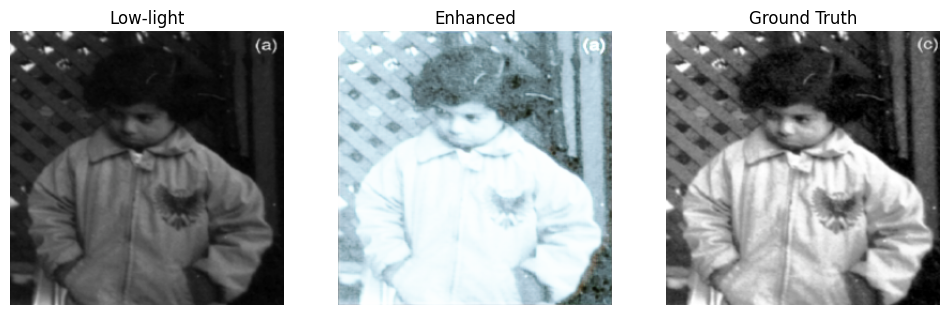

In [14]:
# import matplotlib.pyplot as plt

# # Load a test image
# test_image_path = '/home/hp/Downloads/All_Old_Folders/CV/Projects/Enhanced_ELIEI/data_root/test/low/Test_1.png'
# test_image = load_image(test_image_path)
# org_img=load_image('/home/hp/Downloads/All_Old_Folders/CV/Projects/Enhanced_ELIEI/data_root/test/high/Test_1.png')
# # Predict the enhanced image
# test_image_expanded = np.expand_dims(test_image, axis=0)
# enhanced_image = model.predict(test_image_expanded)

# # Visualize the input and output
# plt.subplot(1, 3, 1)
# plt.title('Low-light Image')
# plt.axis('off')
# plt.imshow(test_image)

# plt.subplot(1, 3, 2)
# plt.title('Enhanced Image')
# plt.axis('off')
# plt.imshow(np.squeeze(enhanced_image))

# plt.subplot(1, 3, 3)
# plt.title('original Image')
# plt.imshow(org_img)
# plt.axis('off')
# plt.show()



from PIL import Image
import numpy as np

# Load using PIL and convert to RGB (drops alpha)
test_image_path = '/home/hp/Downloads/All_Old_Folders/CV/Projects/Enhanced_ELIEI/data_root/test/low/Test_1.png'
org_path = '/home/hp/Downloads/All_Old_Folders/CV/Projects/Enhanced_ELIEI/data_root/test/high/Test_1.png'

def load_rgb(path, target_size=(256,256)):
    img = Image.open(path).convert('RGB')             # <- ensures 3 channels
    img = img.resize(target_size)                     # if your load_image used resizing
    arr = np.array(img).astype(np.float32) / 255.0    # normalize to [0,1] if your model expects that
    return arr

test_image = load_rgb(test_image_path)
org_img = load_rgb(org_path)

# Predict
test_image_expanded = np.expand_dims(test_image, axis=0)
enhanced_image = model.predict(test_image_expanded)

# Visualize (requires matplotlib)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title('Low-light'); plt.axis('off'); plt.imshow(test_image)
plt.subplot(1,3,2); plt.title('Enhanced'); plt.axis('off'); plt.imshow(np.squeeze(enhanced_image))
plt.subplot(1,3,3); plt.title('Ground Truth'); plt.axis('off'); plt.imshow(org_img)
plt.show()


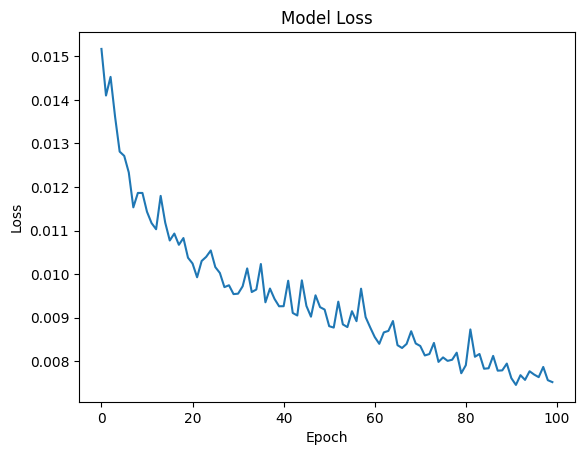

In [15]:
# Plot training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()